In [3]:
## LIBRERIAS
from google.colab import drive, files
import tensorflow as tf 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mlflow
from keras import Model, Sequential
from keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, BatchNormalization, Rescaling, GlobalAveragePooling2D, RandomFlip, Input, RandomContrast
from keras.preprocessing.image import ImageDataGenerator
import random
import os
random.seed(1234)

In [ ]:
## Cargamos Drive e importamos las imágenes de train y test
drive.mount('/content/drive')
!unzip "/content/drive/MyDrive/ColabNotebooks/Mineria_Aspectos_Avanzados/Competicion_Kaggle/Sentinel2LULC_354.zip" -d "/content"
!unzip "/content/drive/MyDrive/ColabNotebooks/Mineria_Aspectos_Avanzados/Competicion_Kaggle/Sentinel2LULC_Test.zip" -d "/content"

In [5]:
## Renombramos las carpetas para que tf las lea en orden
dirnames = sorted(os.listdir("Sentinel2LULC_354"))
for dir in dirnames:
  newname = ""

  if (len(dir.split('_')[0]) == 1):
    newname = '0'+dir.split('_')[0]
  else:
    newname = dir.split('_')[0]

  os.rename("Sentinel2LULC_354/"+dir,"Sentinel2LULC_354/"+newname)

In [6]:
## Leemos las imágenes de train, validacion y test

training = tf.keras.utils.image_dataset_from_directory(
  "Sentinel2LULC_354",
  validation_split=0.2,
  subset="training",
  seed=1234,
  image_size=(224, 224),
  batch_size = 32)

validation = tf.keras.utils.image_dataset_from_directory(
  "Sentinel2LULC_354",
  validation_split=0.2,
  subset="validation",
  seed=1234,
  image_size=(224, 224),
  batch_size = 32)

test = tf.keras.utils.image_dataset_from_directory(
  "Sentinel2LULC_Test",
  shuffle=False,
  labels=None,
  image_size=(224, 224),
  batch_size = 32)


Found 10266 files belonging to 29 classes.
Using 8213 files for training.
Found 10266 files belonging to 29 classes.
Using 2053 files for validation.
Found 1618 files belonging to 1 classes.


43950080/43941136 [==============================] - 0s 0us/step


2022/03/17 14:22:47 INFO mlflow.tracking.fluent: Experiment with name 'EfficientNetB3 con DataAugmentation (ImageNet)' does not exist. Creating a new experiment.


Epoch 1/25
257/257 [==============================] - 109s 335ms/step - loss: 2.5895 - accuracy: 0.5438 - val_loss: 1.2267 - val_accuracy: 0.6352
Epoch 2/25
257/257 [==============================] - 83s 320ms/step - loss: 1.5597 - accuracy: 0.6456 - val_loss: 1.2440 - val_accuracy: 0.6478
Epoch 3/25
257/257 [==============================] - 83s 321ms/step - loss: 1.2216 - accuracy: 0.6804 - val_loss: 0.9716 - val_accuracy: 0.7170
Epoch 4/25
257/257 [==============================] - 83s 322ms/step - loss: 1.0496 - accuracy: 0.6930 - val_loss: 0.9165 - val_accuracy: 0.7112
Epoch 5/25
257/257 [==============================] - 83s 321ms/step - loss: 0.9825 - accuracy: 0.7034 - val_loss: 0.8601 - val_accuracy: 0.7209
Epoch 6/25
257/257 [==============================] - 83s 321ms/step - loss: 0.9204 - accuracy: 0.7057 - val_loss: 0.8527 - val_accuracy: 0.7311
Epoch 7/25
257/257 [==============================] - 82s 319ms/step - loss: 0.9265 - accuracy: 0.7081 - val_loss: 0.9247 - val_a

2022/03/17 14:43:17 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: 'EarlyStopping' object is not iterable


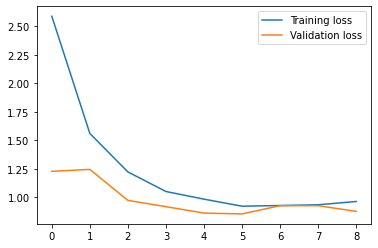

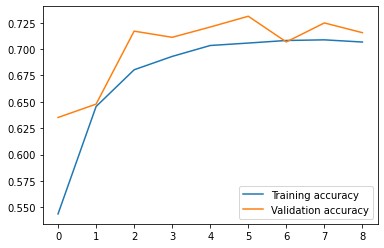

In [7]:
## Función que muestra la evolución de las accuracy de train y validacion
## durante el entrenamiento.
def mostrarEvolucion(hist):

  loss = hist.history['loss']
  val_loss = hist.history['val_loss']
  plt.plot(loss)
  plt.plot(val_loss)
  plt.legend(['Training loss', 'Validation loss'])
  plt.show()

  acc = hist.history['accuracy']
  val_acc = hist.history['val_accuracy']
  plt.plot(acc)
  plt.plot(val_acc)
  plt.legend(['Training accuracy', 'Validation accuracy'])
  plt.show()

## Creamos el modelo con las capas de Data Augmentation.
## Solo RandomFlip parece ir bien. 
augmentation = Sequential([
        RandomFlip()
])

## Vamos a entrenar usando la red EfficietNetB3
base_model = tf.keras.applications.EfficientNetB3(include_top=False,
                                                  weights='imagenet',
                                                  pooling='avg')

base_model.trainable = False

## Capa de entrada
entrada = Input(shape=(224,224,3))

## Capa de normalizacion
normalization = Rescaling(1./255)

## Capa de salida
prediction_layer = Dense(29, activation="softmax")

## Creamos nuestro modelo final juntando todos los submodelos/capas
## anteriores
model = Sequential([
  entrada,
  augmentation,
  base_model,
  BatchNormalization(),
  Dropout(0.2),
  prediction_layer
])

opt = Adam(learning_rate=1e-2)
      
model.compile(loss=SparseCategoricalCrossentropy(from_logits=False),optimizer=opt, 
                  metrics=['accuracy'])

mlflow.set_experiment("EfficientNetB3 con DataAugmentation (ImageNet)")
mlflow.tensorflow.autolog()

with mlflow.start_run():
  callback = EarlyStopping(patience=3,restore_best_weights=True)
  history = model.fit(training,
                    epochs=25,
                    validation_data=validation,
                    callbacks=callback)

  mostrarEvolucion(history)

Epoch 1/20
257/257 [==============================] - 324s 1s/step - loss: 1.3933 - accuracy: 0.6079 - val_loss: 1.8372 - val_accuracy: 0.5144
Epoch 2/20
257/257 [==============================] - 300s 1s/step - loss: 0.7072 - accuracy: 0.7747 - val_loss: 0.5230 - val_accuracy: 0.8281
Epoch 3/20
257/257 [==============================] - 301s 1s/step - loss: 0.5084 - accuracy: 0.8312 - val_loss: 0.3901 - val_accuracy: 0.8675
Epoch 4/20
257/257 [==============================] - 301s 1s/step - loss: 0.4193 - accuracy: 0.8574 - val_loss: 0.3822 - val_accuracy: 0.8743
Epoch 5/20
257/257 [==============================] - 300s 1s/step - loss: 0.3667 - accuracy: 0.8742 - val_loss: 0.3784 - val_accuracy: 0.8714
Epoch 6/20
257/257 [==============================] - 301s 1s/step - loss: 0.3151 - accuracy: 0.8897 - val_loss: 0.3427 - val_accuracy: 0.8860
Epoch 7/20
257/257 [==============================] - 301s 1s/step - loss: 0.2678 - accuracy: 0.9060 - val_loss: 0.3258 - val_accuracy: 0.8948

2022/03/17 15:41:29 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: 'EarlyStopping' object is not iterable


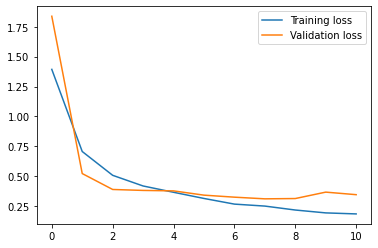

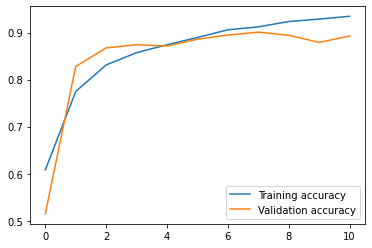

In [8]:
## FINE TUNING: Volvemos a entrenar descongelando algunas capas (menos las BatchNormalization)

def unfreeze_model(model):
    for layer in model.layers[-20:]:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = True

    opt = Adam(learning_rate=1e-4)
    model.compile(loss=SparseCategoricalCrossentropy(from_logits=False),optimizer=opt, 
                  metrics=['accuracy'])


unfreeze_model(model)

with mlflow.start_run():
  callback = EarlyStopping(patience=3,restore_best_weights=True)
  history = model.fit(training,
                    epochs=20,
                    validation_data=validation,
                    callbacks=callback)

  mostrarEvolucion(history)

In [9]:
## Predecimos las clases
y_pred = model.predict(test)
classes = np.argmax(y_pred, axis=1)
classes = np.array(classes)
classes = classes + 1
print(classes)

[10 10 10 ...  9  9 15]


In [10]:
## Creamos el csv con los resultados
d = {'id.jpg': sorted(os.listdir("Sentinel2LULC_Test")), 'label': classes}
df = pd.DataFrame(data=d)
df.to_csv('EfficientNetB3_ImageNet.csv', index=False)
files.download('EfficientNetB3_ImageNet.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>